# test trained models

In [2]:
%load_ext autoreload
# for leonhard
import os
try:
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=" + os.environ["CUDA_HOME"]
except KeyError:
    pass

# Train a Bayesian neural network to classify MNIST using
# Neural SVGD
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
import sys
import os
on_cluster = not os.getenv("HOME") == "/home/lauro"
if on_cluster:
    sys.path.append("/cluster/home/dlauro/projects-2020-Neural-SVGD/learning_particle_gradients/")
sys.path.append("../../experiments/")

import argparse
import matplotlib.pyplot as plt
from jax import vmap, random
import jax.numpy as jnp
import numpy as onp
from tqdm import tqdm
import optax
import bnn
import models
import metrics
import mnist
import config as cfg
import utils
from jax import jit, grad, value_and_grad

# Config
key = random.PRNGKey(0)
MAX_TRAIN_STEPS = 100  # df 100
META_LEARNING_RATE = 5e-3  # df 1e-3; should be as high as possible; regularize w/ max steps
PATIENCE = 5  # df 5; early stopping not v helpful, bc we overfit on all ps

NUM_SAMPLES = 101
DISABLE_PROGRESS_BAR = False
USE_PMAP = False

BATCH_SIZE = 128
LAMBDA_REG = 100
STEP_SIZE = 2e-7 * LAMBDA_REG
PATIENCE = 20
MAX_TRAIN_STEPS = 50

import jax
from tensorflow_probability.substrates import jax as tfp
import uncertainty_metrics.numpy as um

Loading data...


In [3]:
@jit
def get_preds(flat_params, images):
    param_set = vmap(bnn.unravel)(flat_params)
    ensemble_logits = vmap(bnn.model.apply, (0, None))(param_set, images)
    return jnp.mean(vmap(jax.nn.softmax)(ensemble_logits), axis=0)


def expected_calibration_error(flat_params, test_images, test_labels):
    probabilities = get_preds(flat_params, test_images)
    return um.ece(test_labels, probabilities, num_bins=30)


def accuracy(flat_params, test_images, test_labels):
    probabilities = get_preds(flat_params, test_images)
    return 

In [5]:
nvgd_params = onp.load("./nvgd/params.npy")
sgld_params = onp.load("./sgld/params.npy")
svgd_params = onp.load("./svgd/params.npy")

param_list = (nvgd_params, sgld_params, svgd_params)
names = ("NVGD", "SGLD", "SVGD")

In [6]:
tb = next(mnist.test_batches)

In [7]:
print("NVGD:", expected_calibration_error(nvgd_params, *tb))
print("SGLD:", expected_calibration_error(sgld_params, *tb))
print("SVGD:", expected_calibration_error(svgd_params, *tb))

NVGD: 0.11337970965541899
SGLD: 0.05164844635874034
SVGD: 0.04924820456653835


In [8]:
print("NVGD:", bnn.compute_acc_from_flat(nvgd_params))
print("SGLD:", bnn.compute_acc_from_flat(sgld_params))
print("SVGD:", bnn.compute_acc_from_flat(svgd_params))

NVGD: 0.9243683
SGLD: 0.9613174
SVGD: 0.9617923


(array([1109.,   24.,   13.,    9.,    2.,    6.,    7.,    7.,   15.,
          88.]),
 array([0.00331033, 0.09913561, 0.19496089, 0.29078618, 0.38661146,
        0.48243675, 0.57826203, 0.67408735, 0.7699126 , 0.8657379 ,
        0.96156317], dtype=float32),
 <BarContainer object of 10 artists>)

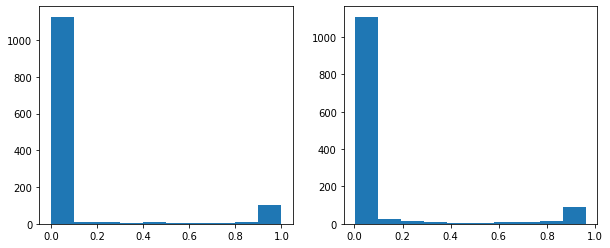

In [9]:
svgd_preds = get_preds(svgd_params, tb[0])
nvgd_preds = get_preds(nvgd_params, tb[0])

fig, axs = plt.subplots(1, 2, figsize=[10, 4])
axs[0].hist(svgd_preds.flatten())
axs[1].hist(nvgd_preds.flatten())

# Corrupted MNIST

In [10]:
import tensorflow_datasets as tfds

In [11]:
corrupted_data, info = tfds.load(name="mnist_corrupted/translate",
                             batch_size=-1,
                             data_dir="/tmp/tfds",
                             with_info=True)
corrupted_data = tfds.as_numpy(corrupted_data)

Shuffling and writing examples to /tmp/tfds/mnist_corrupted/translate/1.0.0.incompleteJV3CLK/mnist_corrupted-train.tfrecord


Shuffling and writing examples to /tmp/tfds/mnist_corrupted/translate/1.0.0.incompleteJV3CLK/mnist_corrupted-test.tfrecord


Dataset mnist_corrupted downloaded and prepared to /tmp/tfds/mnist_corrupted/translate/1.0.0. Subsequent calls will reuse this data.


In [12]:
train_data, test_data = corrupted_data['train'], corrupted_data['test']
test_images, test_labels = test_data['image'], test_data['label']

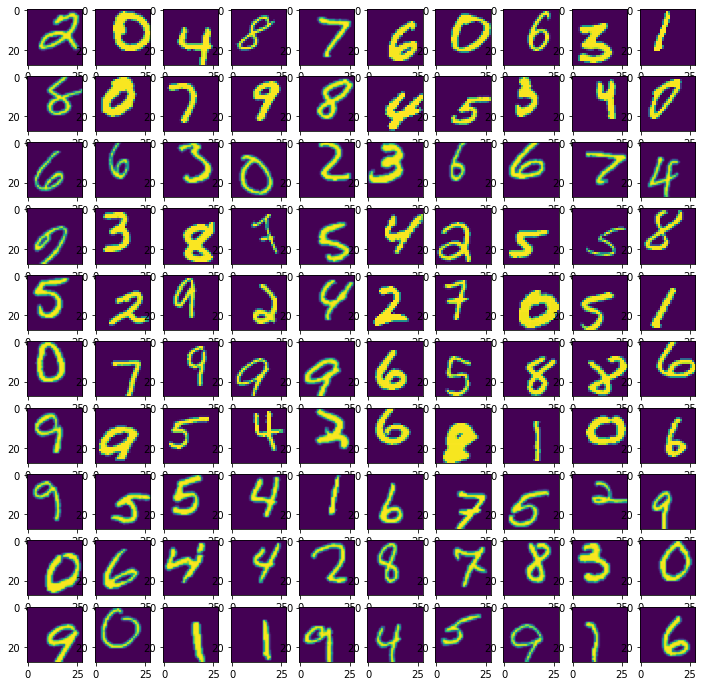

In [13]:
fig, axs = plt.subplots(10, 10, figsize=[12, 12])

for i, ax in zip(range(100), axs.flatten()):
    ax.imshow(test_images[i])

In [14]:
BATCH_SIZE = 500
corrupted_batch = (test_images[:BATCH_SIZE], test_labels[:BATCH_SIZE])

In [15]:
print("ECE:")
print("----")
print("NVGD:", expected_calibration_error(nvgd_params, *corrupted_batch))
print("SGLD:", expected_calibration_error(sgld_params, *corrupted_batch))
print("SVGD:", expected_calibration_error(svgd_params, *corrupted_batch))

ECE:
----
NVGD: 0.4731619866490364
SGLD: 0.3798087869882584
SVGD: 0.39954504960775383


In [16]:
print("accuracy:")
print("---------")
for flat_params, name in zip(param_list, names):
    print(name + ":", bnn.minibatch_accuracy(
        vmap(bnn.unravel)(flat_params),
        *corrupted_batch
        ))

accuracy:
---------
NVGD: 0.16000001
SGLD: 0.24000001
SVGD: 0.23600002


(array([3871.,  339.,  204.,  114.,   98.,   91.,   75.,   67.,   59.,
          82.]),
 array([0.00330387, 0.09867284, 0.19404182, 0.2894108 , 0.38477978,
        0.48014876, 0.5755177 , 0.6708867 , 0.7662557 , 0.86162466,
        0.95699364], dtype=float32),
 <BarContainer object of 10 artists>)

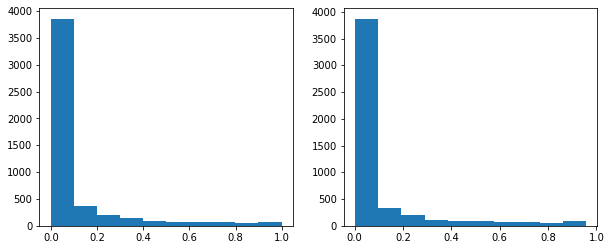

In [17]:
svgd_preds = get_preds(svgd_params, corrupted_batch[0])
nvgd_preds = get_preds(nvgd_params, corrupted_batch[0])

fig, axs = plt.subplots(1, 2, figsize=[10, 4])
axs[0].hist(svgd_preds.flatten())
axs[1].hist(nvgd_preds.flatten())

# OOD detection

In [180]:
# load fashion MNIST
fashion_mnist, info = tfds.load(name="fashion_mnist",
                             batch_size=-1,
                             data_dir="/tmp/tfds",
                             with_info=True)
fashion_mnist = tfds.as_numpy(fashion_mnist)